<a href="https://colab.research.google.com/github/BingHungLee/BHAI-Daily-Practice/blob/main/%5B20210704%5D_Helix_(GA_PSO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Domain knowledge + AI (PSO and GA) BingHung  - 20190716                              


In [1]:
pip install geneticalgs

     |████████████████████████████████| 33.1MB 88kB/s 
     |████████████████████████████████| 204kB 36.3MB/s 
  Created wheel for geneticalgs: filename=geneticalgs-1.0.1-cp37-none-any.whl size=27938 sha256=6f988679cb26f485d80168a04b48ae198181be8711b9dbf7a01bd59aadc9cb76
  Stored in directory: /root/.cache/pip/wheels/bf/8f/fc/c129c1e17c65d13ff23d12d8653a7ceaa71fcac9f27844a476
  Created wheel for bitstring: filename=bitstring-3.1.7-cp37-none-any.whl size=37964 sha256=7cd60216e80c4737a5903ced1117064449445a3530e3892fc02e874073863537
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built geneticalgs bitstring


In [2]:
pip install pyswarms

     |████████████████████████████████| 112kB 7.9MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geneticalgs as pkg_ga
import pyswarms as pkg_pso
from pandas.plotting import scatter_matrix

In [4]:
''' ################################################### 
# STEP 1    Define dataPath and read CSV            
################################################### '''
# Upload CSV From a local drive
from google.colab import files
uploaded = files.upload()

Saving Helix_PSO_GA_20190703.csv to Helix_PSO_GA_20190703.csv


In [5]:
df = pd.read_csv('Helix_PSO_GA_20190703.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1174d590d0>,
      dtype=object)

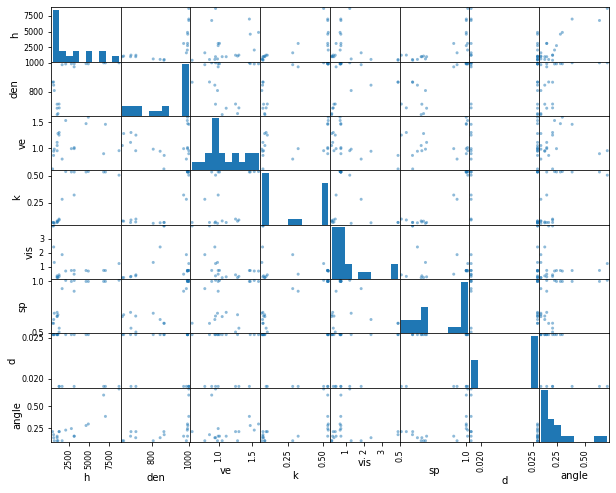

In [6]:
''' ################################################### 
# STEP 2    Observed data relevance            
################################################### '''

scatter_matrix(df[['h','den', 've', 'k', 'vis', 'sp', 'd', 'angle']], figsize = (10, 8))

2021-07-05 01:42:03,149 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=652
2021-07-05 01:42:33,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 652.0925523753001, best pos: [0.84510017 0.08071348 0.73281999 0.81498514]
2021-07-05 01:42:33,986 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=681
2021-07-05 01:43:04,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 680.6727551873614, best pos: [0.76746074 0.08980693 0.77483364 0.93045109]
2021-07-05 01:43:04,869 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=676
2021-07-05 01:43:36,882 - pyswarms.single.global_best - INFO - Optimization fi

PSO LOOCV RMSE: 632.9099324869677


Text(0, 0.5, 'h (PSO LOOCV)')

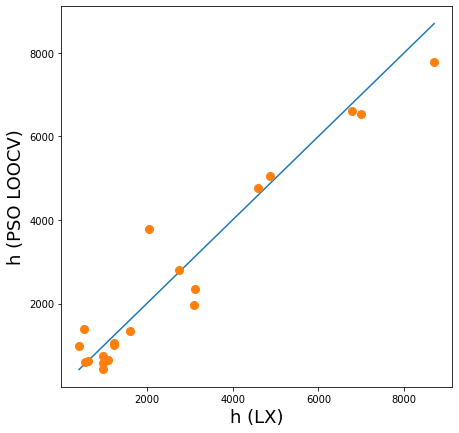

In [7]:

''' ######################################################## 
    # STEP 3    Define boundary upper and lower bound   
             Define GA global parameters
             Copy original data to prevent data overwrite 
   ######################################################## '''

global GA_MISC_DATA 
GA_MISC_DATA = df.copy()
global PARA_UPPER_BDD # numpy.array 1D
global PARA_LOWER_BDD # numpy.array 1D
#紀錄GA最佳化參數
global GA_PARA
global PileRun
PileRun = 0

''' ################################################### 
    # STEP 4    Define domain formula                   
             Reference (ESDU and HTRI　Design Manual) 
   ################################################### '''

def htFun3(theta, k, d_0, den, ve, mu, c_p, phi):
  m = theta[0]; n = theta[1]; a = theta[2]; b = theta[3];
  h_0 = .33 * (k/d_0) * (( (den*d_0*ve)/(mu) )**a) * ((mu*c_p/k)**b)*m*((phi)**n)
  return  h_0


''' ################################################### 
    # STEP 5    Define Object Function for GA                         
   ################################################### '''

def HT_objFun_GA(para_uni):
  para = para_uni*(PARA_UPPER_BDD - PARA_LOWER_BDD) + PARA_LOWER_BDD
  
  df = GA_MISC_DATA.copy()
  
  df_k = np.array(df['k'])
  df_d_0 = np.array(df['d'])
  df_mu = np.array(df['vis'])
  df_c_p = np.array(df['sp'])
  df_phi = np.array(df['angle'])
  df_den = np.array(df['den'])
  df_ve = np.array(df['ve'])
  df_h_0_real = np.array(df['h'])
  
  err_vec = np.zeros(len(df), dtype = float)
  
  for i in range(len(df)):
    h_0_model = htFun3(para, df_k[i], df_d_0[i], df_den[i], 
                       df_ve[i], df_mu[i], df_c_p[i], df_phi[i])
    err_vec[i] = df_h_0_real[i] - h_0_model
  
  return np.sqrt(np.mean(err_vec**2.)) #RMSE
  
''' ################################################### 
    # STEP 6    Define Object Function for PSO                         
   ################################################### '''

def HT_objFun_PSO(para_swarm):
  # 先給定一個長度為粒子群數的零向量
  y_swarm = np.zeros(para_swarm.shape[0])
  # 對每個粒子計算目標式 mse_self 並輸入補充資訊
  for i in range(para_swarm.shape[0]):
    y_swarm[i] = HT_objFun_GA(para_swarm[i,:])
  # 輸出各粒子目標式計算結果的向量
  return y_swarm

# ===============================================
  
if (PileRun == 1):
    
    
    ''' ##################################################
    # STEP 7    Pile run setup for GA and PSO model                         
    ################################################## '''
    nRep = 5 
    
    PARA_UPPER_BDD = np.array([100., 10., 1., 1.])
    PARA_LOWER_BDD = np.array([0., 0., 0., 0.])
    
    GA_N_DIM = 4 # 搜尋維度 4 (兩個模型參數 m, n, a, b)
    GA_TEST_PARA = pd.DataFrame()
    GA_TEST_PARA['N_CHROMOSOME'] = [64, 128, 64, 128, 64, 128, 64, 128]
    GA_TEST_PARA['N_ITERATION'] = [200, 200, 300, 300, 200, 200, 300, 300]
    GA_TEST_PARA['mut_prob'] = [.05, .05, .05, .05, .1, .1, .1, .1]
    #GA_TEST_PARA['mut_type'] 
    #GA_TEST_PARA['cross_prob']
    #GA_TEST_PARA['cross_type']
    GA_TEST_RMSE = np.zeros((nRep, len(GA_TEST_PARA)))
    GA_TEST_TIME = np.zeros((nRep, len(GA_TEST_PARA)))
    
    PSO_N_DIM = 4 # 搜尋維度 4 (兩個模型參數 m, n, a, b)
    PSO_TEST_PARA = pd.DataFrame()
    PSO_TEST_PARA['N_PARTICLE'] = [32, 64, 128, 32, 64, 128, 32, 64, 128]
    PSO_TEST_PARA['N_ITERATION'] = [100, 100, 100, 200, 200, 200, 300, 300, 300]
    PSO_TEST_RMSE = np.zeros((nRep, len(PSO_TEST_PARA)))
    PSO_TEST_TIME = np.zeros((nRep, len(PSO_TEST_PARA)))
    
# ===============================================================
    ''' #################################################################################
    # STEP 8    Execute GA algorithm -> Calulate computing time, RMSE and (m,n,a,b)                        
    ################################################################################# '''

    for iGA in range(len(GA_TEST_PARA)):
      for iRep in range(nRep):
        # GA 參數
        GA_N_CHROMOSOME = GA_TEST_PARA['N_CHROMOSOME'].loc[iGA] # GA 群體大小
        GA_N_ITERATION = GA_TEST_PARA['N_ITERATION'].loc[iGA] # GA 演化次數
        # 設定 GA 框架
        ga_res = pkg_ga.real_ga.RealGA(HT_objFun_GA, 
                                       optim = 'min',
                                       mut_prob = GA_TEST_PARA['mut_prob'].loc[iGA],    # 突變機率
                                       mut_type = 1,       # 突變點數
                                       cross_prob = 0.95,  # 交換機率
                                       cross_type = 1)     # 交換點數
        start_time = datetime.datetime.now() # 記錄開始時#間
        ga_res.init_random_population(size = GA_N_CHROMOSOME, dim = GA_N_DIM, interval = (0, 1)) # 給定 GA 初始值
        ga_res.run(GA_N_ITERATION) # 執行 GA for GA_N_ITERATION 次演化
        end_time = datetime.datetime.now() # 紀錄結束時間
        cpu_time = (end_time - start_time).total_seconds() # 計算運算時間
        GA_TEST_RMSE[iRep, iGA] = ga_res.best_fitness     # 最佳解 (最小的 f 值)
        GA_TEST_TIME[iRep, iGA] = cpu_time
        print('------------------------------------')
        print('GA test set ' + str(iGA+1) + ' (rep ' + str(iRep+1) + ')' + ':')
        print(GA_TEST_PARA.loc[iGA])
        print('\nRMSE = ' + str(ga_res.best_fitness))
        print('Computing Time = ' + str(cpu_time) + ' seconds')
        print('------------------------------------')

# ===============================================================
    ''' #################################################################################
    # STEP 9    Execute PSO algorithm -> Calulate computing time, RMSE and (m,n,a,b)                        
    ################################################################################# '''


    for iPSO in range(len(PSO_TEST_PARA)):
      for iRep in range(nRep):
        # GA 參數
        PSO_N_PARTICLE = PSO_TEST_PARA['N_PARTICLE'].loc[iPSO] # 粒子群數
        PSO_N_ITERATION = PSO_TEST_PARA['N_ITERATION'].loc[iPSO] # PSO 演化次數
        PSO_OPTIONS = {'c1':2.0, 'c2':2.0, 'w':0.9} # PSO 其他設定 
        # 設定 PSO 框架
        pso_res = pkg_pso.single.GlobalBestPSO(n_particles = PSO_N_PARTICLE, 
                                               dimensions = PSO_N_DIM, 
                                               options = PSO_OPTIONS, 
                                               bounds = ([0]*PSO_N_DIM, [1]*PSO_N_DIM))
        start_time = datetime.datetime.now() # 記錄開始時間
        best_y, best_x = pso_res.optimize(HT_objFun_PSO,  # 執行 PSO for PSO_N_ITERATION 次演化
                                          iters = PSO_N_ITERATION)
        end_time = datetime.datetime.now() # 記錄結束時間
        cpu_time = (end_time - start_time).total_seconds() # 計算運算時間
        PSO_TEST_RMSE[iRep, iPSO] = best_y     # 最佳解 (最小的 f 值)
        PSO_TEST_TIME[iRep, iPSO] = cpu_time
        print('------------------------------------')
        print('PSO test set ' + str(iPSO+1) + ' (rep ' + str(iRep+1) + ')' + ':')
        print(PSO_TEST_PARA.loc[iPSO])
        print('\nRMSE = ' + str(best_y))
        print('Computing Time = ' + str(cpu_time) + ' seconds')
        print('------------------------------------')

# ===============================================================
        
    ''' ################################################################################################
    # STEP 10    Print RMSE(Best, Mid, Worst), Stability, Computing Time -> Find the best Settings                        
    ################################################################################################ '''
    
    OPTIM_TEST_COMP = pd.DataFrame(columns = ['Algorithm', 'Best', 'Mid', 'Worst', 'Stability', 'CPU_TIME'])
    
    counter = 0
    for iCol in range(GA_TEST_RMSE.shape[1]):
      # 重複 N_REP 中的最小值(最佳)、中間值、最大值(最差)
      GA_PERF = np.percentile(GA_TEST_RMSE[:,iCol], np.array([0, 50, 100]))
      # 取重複 N_REP 次的結果計算標準差，值越小表示演算法越穩定
      GA_STAB = np.std(GA_TEST_RMSE[:,iCol])
      # 計算 N_REP 次的平均計算時間，越小算越快 
      GA_TIME = np.mean(GA_TEST_TIME[:,iCol])
      OPTIM_TEST_COMP.loc[counter] = ['GA_' + str(iCol)] + list(GA_PERF) + [GA_STAB, GA_TIME]
      counter += 1
      
    for iCol in range(PSO_TEST_RMSE.shape[1]):
      # 重複 N_REP 中的最小值(最佳)、中間值、最大值(最差)
      PSO_PERF = np.percentile(PSO_TEST_RMSE[:,iCol], np.array([0, 50, 100]))
      # 取重複 N_REP 次的結果計算標準差，值越小表示演算法越穩定
      PSO_STAB = np.std(PSO_TEST_RMSE[:,iCol])
      # 計算 N_REP 次的平均計算時間，越小算越快 
      PSO_TIME = np.mean(PSO_TEST_TIME[:,iCol])
      OPTIM_TEST_COMP.loc[counter] = ['PSO_' + str(iCol)] + list(PSO_PERF) + [PSO_STAB, PSO_TIME]  
      counter += 1
      
    print(OPTIM_TEST_COMP)


''' #########################################################################################
    # STEP 11    Setup the model with the best settings given by previous anlysis (pile run)
              Jump to this block and skip STEP 7 - 10 for second run                       
  ######################################################################################### '''

def pso_model_fit(dataDf):
  global PARA_UPPER_BDD
  global PARA_LOWER_BDD
  PARA_UPPER_BDD = np.array([100., 10., 1., 1.])
  PARA_LOWER_BDD = np.array([0., 0., 0., 0.])
  # 設定 PSO 參數
  PSO_N_DIM = 4 # 搜尋維度 4 (兩個模型參數 m, n, a, b)
  PSO_N_PARTICLE = 128 # 粒子群數
  PSO_N_ITERATION = 300 # PSO 演化次數
  PSO_OPTIONS = {'c1':2.0, 'c2':2.0, 'w':0.9} # PSO 其他設定 
  # 設定 PSO 框架
  pso_res = pkg_pso.single.GlobalBestPSO(n_particles = PSO_N_PARTICLE, 
                                         dimensions = PSO_N_DIM, 
                                         options = PSO_OPTIONS, 
                                         bounds = ([0]*PSO_N_DIM, [1]*PSO_N_DIM))
  start_time = datetime.datetime.now() # 記錄開始時間
  best_y, best_x = pso_res.optimize(HT_objFun_PSO,  # 執行 PSO for PSO_N_ITERATION 次演化
                                    iters = PSO_N_ITERATION)
  end_time = datetime.datetime.now() # 記錄結束時間
  cpu_time = (end_time - start_time).total_seconds() # 計算運算時間
  # PSO 結果
  return {'coef': best_x*(PARA_UPPER_BDD - PARA_LOWER_BDD) + PARA_LOWER_BDD,  # 最佳模型參數 (m, n, a, b)
          'rmse': best_y,  # 最佳解 (最小的 rmse 值)
          'cputime': cpu_time}

def pso_model_predict(dataDf, PSO_MODEL):
  pso_para = PSO_MODEL['coef']
  pso_h_0_pso = np.zeros(len(dataDf), dtype = float)
  for i in range(len(dataDf)):
    phi = dataDf['angle'].loc[i]
    h_0_model_pso = htFun3(pso_para, dataDf['k'].loc[i], dataDf['d'].loc[i], dataDf['den'].loc[i], 
                       dataDf['ve'].loc[i], dataDf['vis'].loc[i], dataDf['sp'].loc[i], phi)
    pso_h_0_pso[i] = h_0_model_pso
  return pso_h_0_pso


''' ###############################################################
    # STEP 12  Model Prediction Validation - leave-one-out (LOOCV)                         
   ############################################################### '''


nfold = len(df) # leave-one-out
# 複製好幾個 [0 1 2] index 序列，抓前 x.shape[0] 個就夠了
folds_ordered = np.tile(np.arange(nfold), len(df))[:len(df)]
# 隨機打亂 [0 1 2] index 序列
# 務必要設定 random seed (驗證結果再現性)
np.random.seed(1)
folds = np.random.permutation(folds_ordered)
# 預留空間存放各模型的預測值
kfold_ytest_pso = np.zeros(len(df)) # 網路
# 執行 K-fold Cross Validation
for i in range(nfold):
  # 取第 i 次 K-fold 的訓練資料
  df_train = (df.loc[(folds != i)].copy()).reset_index(drop = True)
  # 取第 i 次 K-fold 的測試資料
  df_test  = (df.loc[(folds == i)].copy()).reset_index(drop = True)
  # 用訓練資料 _train 建 PSO 模型
  PSO_MODEL_CV = pso_model_fit(df_train)
  # 用 PSO 模型預測測試資料 _test 
  y_pred = pso_model_predict(df_test, PSO_MODEL_CV)
  # 將預測值 y_pred 儲存回 kfold_ytest_pso 中相對應的位置
  kfold_ytest_pso[folds == i] = y_pred 

kfold_rmse_pso = np.sqrt(np.mean((df['h'] - kfold_ytest_pso)**2))
print('PSO LOOCV RMSE: ' + str(kfold_rmse_pso))

# PSO繪圖
figLim_pso = [np.array(min(np.min(df['h']), np.min(kfold_ytest_pso))),
          np.array(max(np.max(df['h']), np.max(kfold_ytest_pso)))]

fig = plt.figure(figsize = (7,7))
ax = plt.subplot(1,1,1)
ax.plot(np.array(figLim_pso), np.array(figLim_pso))

ax.plot(np.array(df['h']), kfold_ytest_pso, '.', markersize = 16)
ax.set_xlabel('h (LX)', fontsize = 18)
ax.set_ylabel('h (PSO LOOCV)', fontsize = 18)

2021-07-05 01:52:16,361 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=641
2021-07-05 01:52:46,750 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 640.6807780933166, best pos: [0.86211255 0.0827397  0.72734495 0.80378489]


PSO-computed Model Parameters [m, n, a, b]:
[86.21125497  0.82739701  0.72734495  0.80378489]
PSO Fitted RMSE: 640.6807780933166
     h (LX)  h (PSO-LOOCV)  h (PSO-Fitted)
0   7001.73    6540.641320     6539.902572
1   6776.87    6595.296532     6890.005512
2   8695.88    7772.877879     8164.878133
3    990.20     425.953915      526.555144
4    541.68    1386.889613      956.673765
5    421.42     972.723153      856.835422
6    555.12     612.345409      835.502190
7    986.64     740.869044      828.553263
8    628.58     632.444400      664.239926
9   1086.32     640.759763      625.513026
10   986.64     571.751622      683.438865
11  1607.10    1339.972260     1265.107911
12  3103.10    1962.157073     1862.193775
13  1224.30    1008.010324     1101.973895
14  1243.20    1050.385120     1121.222433
15  4870.95    5054.417089     5172.184794
16  3113.40    2336.209140     2218.289731
17  4587.49    4756.179785     4657.996822
18  2758.50    2806.143397     3124.923119
19  2051.84

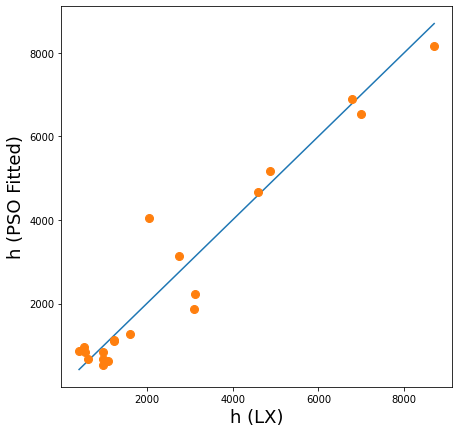

In [8]:
''' ################################################
    # STEP 13  Model Prediction  - Fitted (All In)                        
    ################################################ '''


PSO_MODEL = pso_model_fit(df)
PSO_MODEL_FITTED = pso_model_predict(df, PSO_MODEL)

print('PSO-computed Model Parameters [m, n, a, b]:')
print(PSO_MODEL['coef'])

rmse_pso = np.sqrt(np.mean((df['h'] - PSO_MODEL_FITTED)**2))
print('PSO Fitted RMSE: ' + str(rmse_pso))

# PSO繪圖
figLim_pso = [np.array(min(np.min(df['h']), np.min(PSO_MODEL_FITTED))),
          np.array(max(np.max(df['h']), np.max(PSO_MODEL_FITTED)))]

fig = plt.figure(figsize = (7,7))
ax = plt.subplot(1,1,1)
ax.plot(np.array(figLim_pso), np.array(figLim_pso))

ax.plot(np.array(df['h']), PSO_MODEL_FITTED, '.', markersize = 16)
ax.set_xlabel('h (LX)', fontsize = 18)
ax.set_ylabel('h (PSO Fitted)', fontsize = 18)

#
optim_result = pd.DataFrame(np.array([df['h'], kfold_ytest_pso, PSO_MODEL_FITTED]).transpose(), 
                          columns = ['h (LX)', 'h (PSO-LOOCV)', 'h (PSO-Fitted)'])
print(optim_result)
#optim_result.to_csv(os.path.join(dataPath,'OPTIM_RESULT.csv'))
#optim_result.to_csv(os.path.join('C:/tmp/FHX','FHX610A_PSO.csv'))
# =====================================